In [1]:
!git clone https://github.com/addtt/multi-object-datasets.git
new_directory = "/content/multi-object-datasets"
import os
if not os.path.exists(new_directory):
    print("fail")
os.chdir(new_directory)

Cloning into 'multi-object-datasets'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 277 (delta 25), reused 23 (delta 23), pack-reused 244 (from 1)
Receiving objects: 100% (277/277), 40.40 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (143/143), done.


Training Process

Input Data.

In [2]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
class CostomizeMultiObjectDataset(Dataset):
  def __init__(self, data_path, train, split=0.9, max_samples=None):
    super().__init__()
    data = np.load(data_path, allow_pickle=True)
    self.images = np.asarray(data['x'], dtype=np.float32) / 255
    self.images = np.transpose(self.images, [0, 3, 1, 2])  # [N, 3, 64, 64]
    total_samples = len(self.images)
    if max_samples is not None:
        total_samples = min(max_samples, total_samples)
        self.images = self.images[:total_samples]
    split_idx = int(split * total_samples)
    if train:
        self.indices = list(range(split_idx))
    else:
        self.indices = list(range(split_idx, total_samples))
    self.images = torch.from_numpy(self.images[self.indices])

  def __getitem__(self, index):
    img = self.images[index]  # [3, 64, 64]
    condition = img[:, :, 32:33].reshape(-1)  # [192]
    target = img  # [3, 64, 64]
    return condition, target

  def __len__(self):
    return len(self.indices)
def custom_collate_fn(batch):
  conditions = torch.stack([item[0] for item in batch])  # [batch_size, 192]
  targets = torch.stack([item[1] for item in batch])     # [batch_size, 3, 64, 64]
  return conditions, targets

In [3]:
from multiobject.pytorch import MultiObjectDataLoader, MultiObjectDataset
batch_size = 32
dataset_path = '/content/multi-object-datasets/generated/dsprites/multi_dsprites_color_012.npz'
# train_set = MultiObjectDataset(dataset_path, train=True)

train_set = CostomizeMultiObjectDataset(dataset_path, train=True, max_samples=6000)
test_set = CostomizeMultiObjectDataset(dataset_path, train=False, max_samples=1000)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [4]:
# import matplotlib.pyplot as plt

# for i, batch in enumerate(train_loader):
#     if(i >= 20):
#       break
#     images, labels = batch
#     # print("Image", images)
#     # print("Labels:", labels)

#     image = images[0]

#     if len(image.shape) == 3:
#         image = image.permute(1, 2, 0)
#     image = image.numpy()
#     print(image.shape)
#     print(labels['shape'].shape)
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
#     break

Encoder

In [5]:
import torch.nn as nn
import torch
import torch.nn.functional as F
class Encoder(nn.Module):
  def __init__(self, latent_dim=20, condition_dim=192):
    super(Encoder, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(128)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.condition_conv = nn.Conv2d(condition_dim, 128, kernel_size=1, stride=1, padding=0)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(512)

    self.conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=1, padding=0)
    self.bn5 = nn.BatchNorm2d(1024)

    self.conv6 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0)
    self.bn6 = nn.BatchNorm2d(512)

    self.fc_mu = nn.Linear(512 + condition_dim, latent_dim)
    self.fc_logvar = nn.Linear(512 + condition_dim, latent_dim)
    # Dropout
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, img, condition):
    # img: [batch, 3, 64, 64], condition: [batch, 192]
    x = F.relu(self.bn1(self.conv1(img)))  # [batch, 64, 32, 32]
    x = F.relu(self.bn2(self.conv2(x)))    # [batch, 128, 16, 16]


    condition_map = condition.unsqueeze(-1).unsqueeze(-1)  # [batch, 192] -> [batch, 192, 1, 1]
    condition_map = self.condition_conv(condition_map)     # [batch, 128, 1, 1]
    condition_map = condition_map.expand(-1, -1, 16, 16)   # [batch, 128, 16, 16]，
    x = x + condition_map
    x = F.relu(self.bn3(self.conv3(x)))     # [batch, 256, 8, 8]

    x = F.relu(self.bn4(self.conv4(x)))     # [batch, 512, 4, 4]
    x = F.relu(self.bn5(self.conv5(x)))     # [batch, 1024, 1, 1]
    x = F.relu(self.bn6(self.conv6(x)))     # [batch, 512, 1, 1]

    x = x.view(x.size(0), -1)  # [batch, 512]
    x = self.dropout(x)
    x = torch.cat([x, condition], dim=-1)   # [batch, 512 + 192]
    mu = self.fc_mu(x)  # [batch, 20]
    logvar = self.fc_logvar(x)  # [batch, 20]
    return mu, logvar

Decoder

In [6]:
class Decoder(nn.Module):
  def __init__(self, latent_dim=20, condition_dim=192):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(latent_dim + condition_dim, 1024 * 4 * 4)
    self.bn0 = nn.BatchNorm2d(1024)
    self.conv_trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv_trans2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.conv_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv_trans4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv_trans5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    self.conv_final = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)

    self.skip_conv1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
    self.skip_conv2 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
    self.skip_conv3 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0)

  def forward(self, z, condition):
    x = torch.cat([z, condition], dim=-1)
    x = self.fc(x)
    x = x.view(-1, 1024, 4, 4)
    x = F.relu(self.bn0(x))

    x1 = self.conv_trans1(x)
    x1 = F.relu(self.bn1(x1))

    skip1 = F.interpolate(self.skip_conv1(x1), size=(16, 16), mode='bilinear', align_corners=False)
    x2 = self.conv_trans2(x1)
    x2 = x2 + skip1
    x2 = F.relu(self.bn2(x2))

    skip2 = F.interpolate(self.skip_conv2(x2), size=(32, 32), mode='bilinear', align_corners=False)
    x3 = self.conv_trans3(x2)
    x3 = x3 + skip2
    x3 = F.relu(self.bn3(x3))

    skip3 = F.interpolate(self.skip_conv3(x3), size=(64, 64), mode='bilinear', align_corners=False)
    x4 = self.conv_trans4(x3)
    x4 = x4 + skip3
    x4 = F.relu(self.bn4(x4))

    x5 = F.relu(self.bn5(self.conv_trans5(x4)))
    x = torch.sigmoid(self.conv_final(x5))
    return x

CVAE model

In [7]:

class CVAE(nn.Module):
  def __init__(self, latent_dim=20, condition_dim=192, output_channels=3):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.condition_dim = condition_dim
    self.output_channels = output_channels
    self.encoder = Encoder(latent_dim=latent_dim, condition_dim=condition_dim)
    self.decoder = Decoder(latent_dim=latent_dim, condition_dim=condition_dim)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x, y):
    mu, logvar = self.encoder(y, x)
    z = self.reparameterize(mu, logvar)
    y_hat = self.decoder(z, x)
    return y_hat, mu, logvar

Loss Function + Optimization.

In [8]:
def loss_function(x, x_hat, mu, logvar, beta=1.0): # elbo
  reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum') # (smaller is better) dissimilarity between X_hat(reconstructed) and X (original)
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # the dissimilarity of distribution between q(z|x) [output] and p(z) [real]
  return reconstruction_loss + beta * kl_div
def train_cvae(train_dataloader, test_loader, epochs=10, batch_size=16, learning_rate=0.001):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = CVAE(latent_dim=20, condition_dim=192).to(device)
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
  dataloader = train_dataloader

  C_start = 0.5
  C_end = 25
  gamma = 1.5

  for epoch in range(epochs):
    total_loss = 0
    C = C_start + (C_end - C_start) * epoch / (epochs - 1)
    for batch in dataloader:
      x = batch[0].to(device)  # [batch, 192]
      y = batch[1].to(device)  # [batch, 3, 64, 64]

      optimizer.zero_grad()
      y_hat, mu, logvar = model(x, y)

      loss = F.mse_loss(y_hat, y, reduction='sum') + gamma * abs(
          -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) - C
      )
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    avg_test_loss = total_loss/len(dataloader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_test_loss:.4f}')

  dataloader = test_loader
  model.eval()
  total_test_loss = 0
  with torch.no_grad():
    for batch in dataloader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        y_hat, mu, logvar = model(x, y)
        loss = loss_function(y, y_hat, mu, logvar)
        total_test_loss += loss.item()
  avg_test_loss = total_test_loss / len(test_loader.dataset)
  print(f'Test ELBO Loss: {avg_test_loss:.4f}')

  return model

In [9]:
trained_cvae = train_cvae(train_loader, test_loader, epochs=100, batch_size=16, learning_rate=0.001)

Epoch 1/100, Loss: 9167.0602
Epoch 2/100, Loss: 4154.1882
Epoch 3/100, Loss: 3829.3290
Epoch 4/100, Loss: 3640.1829
Epoch 5/100, Loss: 3570.8288
Epoch 6/100, Loss: 3518.9026
Epoch 7/100, Loss: 3462.1421
Epoch 8/100, Loss: 3432.5125
Epoch 9/100, Loss: 3411.9911
Epoch 10/100, Loss: 3373.9394
Epoch 11/100, Loss: 3353.0018
Epoch 12/100, Loss: 3338.4765
Epoch 13/100, Loss: 3297.3938
Epoch 14/100, Loss: 3301.7382
Epoch 15/100, Loss: 3282.4105
Epoch 16/100, Loss: 3266.4124
Epoch 17/100, Loss: 3255.6854
Epoch 18/100, Loss: 3228.2720
Epoch 19/100, Loss: 3225.9743
Epoch 20/100, Loss: 3211.1946
Epoch 21/100, Loss: 3177.3754
Epoch 22/100, Loss: 3121.6018
Epoch 23/100, Loss: 3092.3891
Epoch 24/100, Loss: 3034.6241
Epoch 25/100, Loss: 3003.2444
Epoch 26/100, Loss: 2962.9429
Epoch 27/100, Loss: 2932.4311
Epoch 28/100, Loss: 2910.6696
Epoch 29/100, Loss: 2857.1016
Epoch 30/100, Loss: 2813.5832
Epoch 31/100, Loss: 2746.7170
Epoch 32/100, Loss: 2695.5120
Epoch 33/100, Loss: 2656.7713
Epoch 34/100, Loss:

Generation Visualization

In [10]:
import matplotlib.pyplot as plt
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # For CUDA (if applicable)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
  torch.backends.cudnn.benchmark = False
def interpolate_images(decoder, z1, z2, condition, num_steps=10, device='cpu'):
  decoder.eval()
  interpolated_images = []
  with torch.no_grad():
    for alpha in torch.linspace(0, 1, num_steps).to(device):
      z_interp = (1 - alpha) * z1 + alpha * z2  # [batch_size, 20]
      x_interp = decoder(z_interp, condition)  # [batch_size, 3, 64, 64]
      interpolated_images.append(x_interp)
  return torch.stack(interpolated_images)  # [num_steps, batch_size, 3, 64, 64]

def plot_interpolated_images(interpolated_images):
  interpolated_images = interpolated_images.cpu().numpy()  # [num_steps, batch_size, 3, 64, 64]
  num_steps, batch_size = interpolated_images.shape[0], interpolated_images.shape[1]
  fig, axes = plt.subplots(batch_size, num_steps, figsize=(num_steps * 2, batch_size * 2))
  num_cols = 3
  num_rows = 4
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))  # Adjust figure size
  axes = axes.ravel() if num_rows * num_cols > 1 else [axes]
  for i in range(batch_size):
    for j in range(num_steps):
      idx = i * num_cols + j
      if idx < len(axes):
        ax = axes[idx]
        img = interpolated_images[j, i].transpose(1, 2, 0)  # [64, 64, 3]
        ax.imshow(img)  # Plot the image
        ax.axis('off')
        if i == 0:
          ax.set_title(f'α={j/(num_steps-1):.2f}')
  for idx in range(batch_size * num_cols, len(axes)):
    axes[idx].axis('off')
  plt.tight_layout()
  plt.show()
def test_train_and_interpolate(train_loader, trained_cvae):
  set_seed(42)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  latent_dim = 20

  # trained decoder
  decoder = trained_cvae.decoder

  # random z1, z2 with fixed x
  z1 = torch.randn(1, latent_dim).to(device)  # [1, 20]
  z2 = torch.randn(1, latent_dim).to(device)  # [1, 20]
  # get condition from dataset
  data_iter = iter(train_loader)
  x1, y1 = next(data_iter)  # x1: [batch_size, 192], y1: [batch_size, 3, 64, 64]
  condition = x1[:1].to(device)  # [1, 192]
  print("Interpolating from random z1, z2 with condition x1:")
  interpolated_images = interpolate_images(decoder, z1, z2, condition, num_steps=10, device=device)
  print(f"Interpolated images shape: {interpolated_images.shape}")
  plot_interpolated_images(interpolated_images)

  # databased z1, z2
  x1, y1 = x1[:1].to(device), y1[:1].to(device)  # [1, 192], [1, 3, 64, 64]
  x2, y2 = next(data_iter)
  x2, y2 = x2[:1].to(device), y2[:1].to(device)  # [1, 192], [1, 3, 64, 64]

  mu1, logvar1 = trained_cvae.encoder(y1, x1)  # y1 is img，x1 is condition
  z1_data = trained_cvae.reparameterize(mu1, logvar1)
  mu2, logvar2 = trained_cvae.encoder(y2, x2)  # y2 is img，x2 is condition
  z2_data = trained_cvae.reparameterize(mu2, logvar2)
  print("Interpolating from data-derived z1, z2 with condition x1:")
  interpolated_images_data = interpolate_images(decoder, z1_data, z2_data, condition, num_steps=10, device=device)
  print(f"Interpolated images shape: {interpolated_images_data.shape}")
  plot_interpolated_images(interpolated_images_data)


Interpolating from random z1, z2 with condition x1:
Interpolated images shape: torch.Size([10, 1, 3, 64, 64])


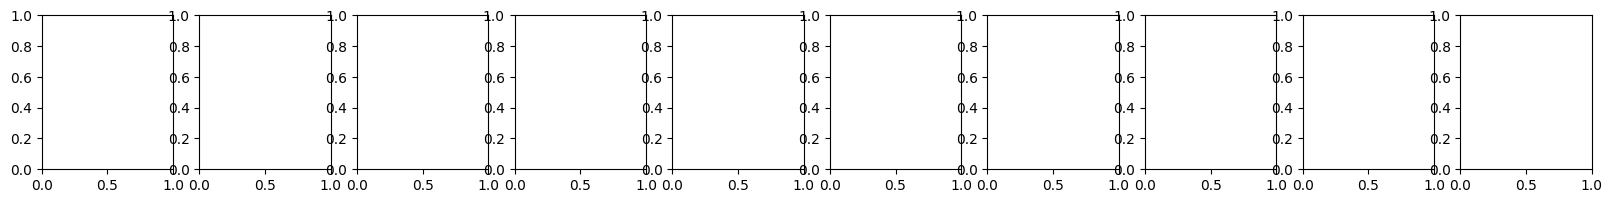

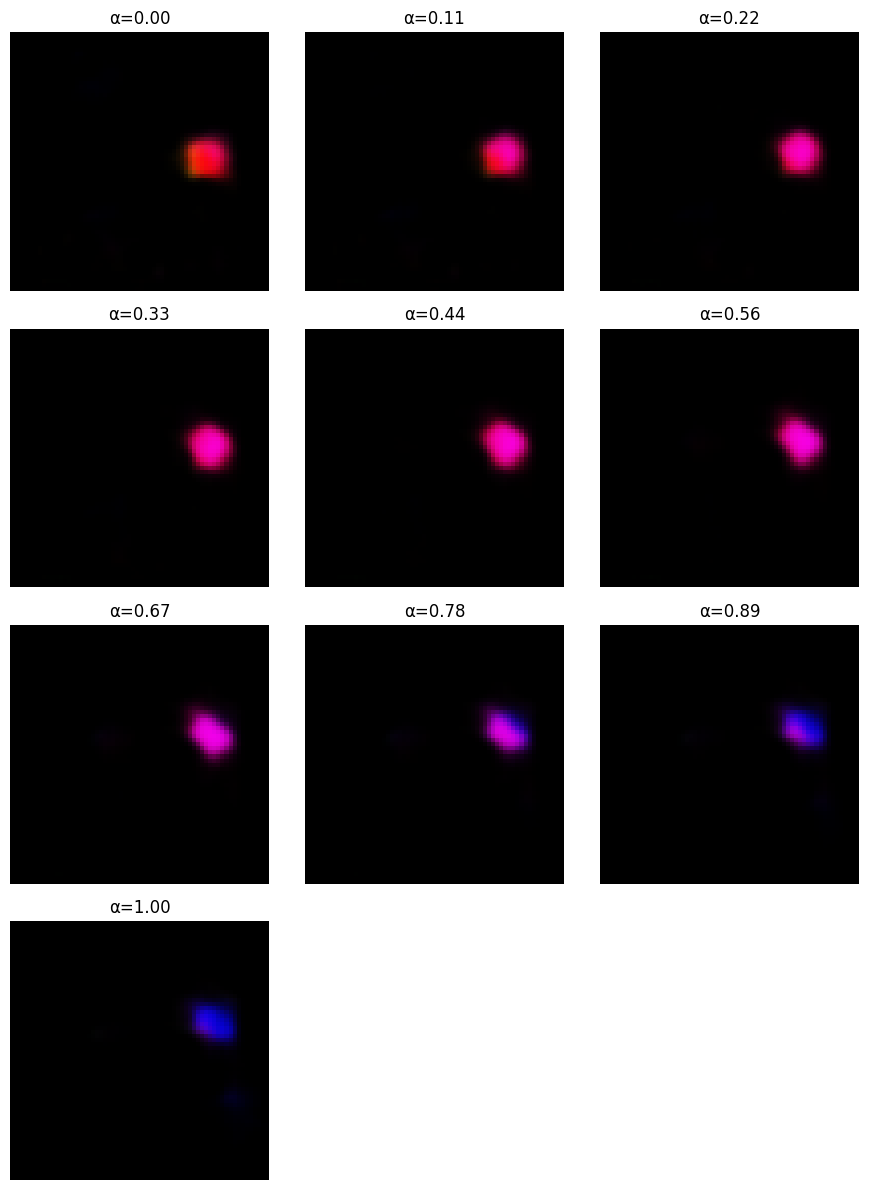

Interpolating from data-derived z1, z2 with condition x1:
Interpolated images shape: torch.Size([10, 1, 3, 64, 64])


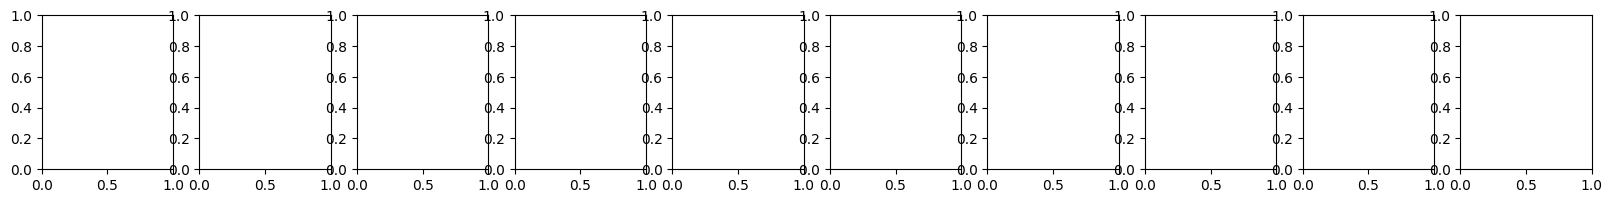

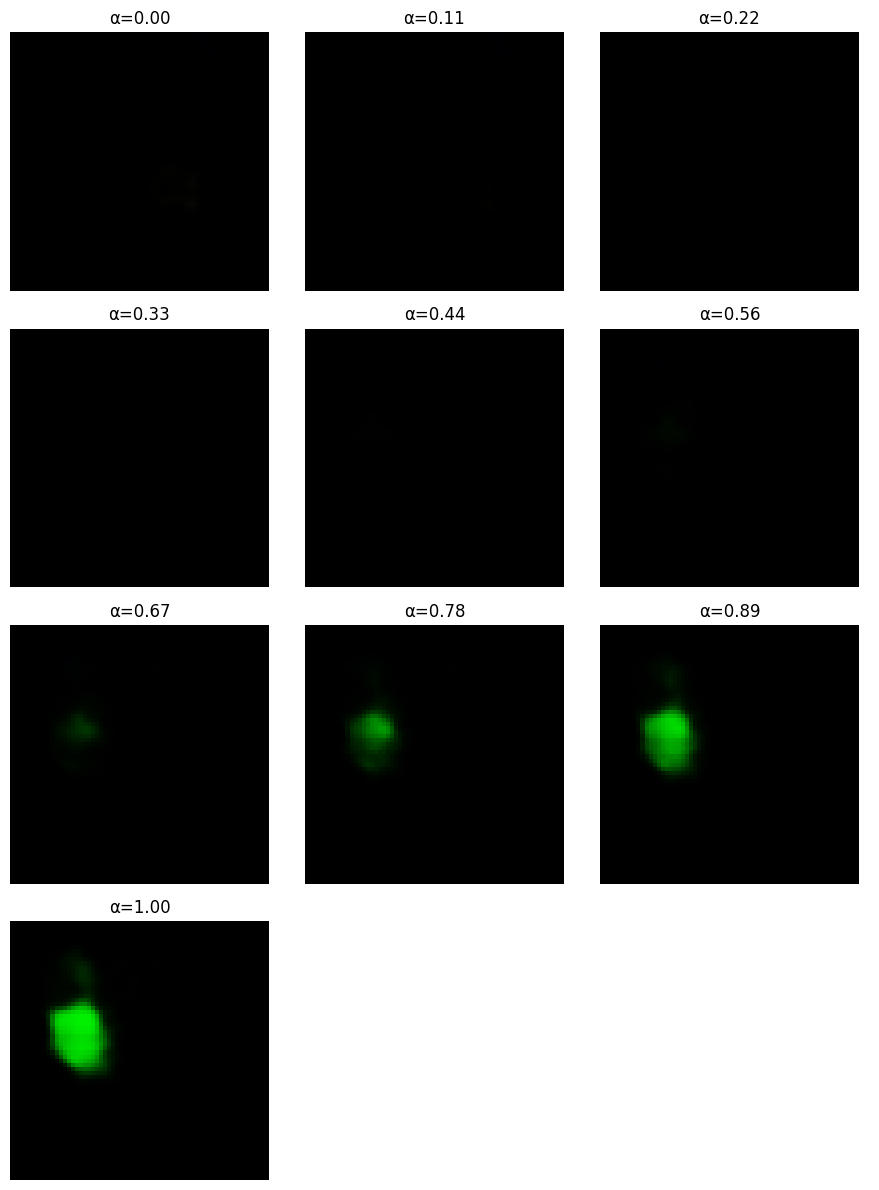

In [11]:
test_train_and_interpolate(train_loader, trained_cvae)